## Introduction

For the 2019 Fantasy Football season, ESPN implmented something called "Final Projected Rankings". It's an algorithm they use (allegedly an algorithm anyway...) that takes into account record, points, remaining schedule, and lineups to predict the final standing of each team at the end of the fantasy regular season.

I believe a method exists to find this value by searching through the JSON from accessing ESPN via API. I instead manually tracked these values daily and compiled them into an Excel sheet, which I will be using as the source data for the purpose of this visualization and comparison.

We will visualize the daily final projected ranking, subset it weekly as the graphic can get very busy/messy, and compare the projected rankings at the first day to the actual final standing.


### Necessary Libraries and Source Data

In [1]:
#required libraries
library(readxl)
library(janitor)
library(tidyverse)
library(directlabels)
library(ggrepel)
library(gridExtra)

#Importing the source and subsetting data to not show the team name
source <- read_excel("C:/Users/NTellaku/Documents/R/ff/Final Projected Rankings.xlsx",
                     sheet = "10 Guys One Cup")

head(source)

Warning message:
"package 'janitor' was built under R version 3.6.2"
Attaching package: 'janitor'

The following objects are masked from 'package:stats':

    chisq.test, fisher.test

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.1.1       v purrr   0.3.2  
v tibble  2.1.1       v dplyr   0.8.0.1
v tidyr   0.8.3       v stringr 1.4.0  
v readr   1.3.1       v forcats 0.4.0  
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Warning message:
"package 'directlabels' was built under R version 3.6.2"Warning message:
"package 'ggrepel' was built under R version 3.6.2"Warning message:
"package 'gridExtra' was

Team,43712,43718,43719,43720,43721,43722,43724,43725,43726,...,43787,43788,43789,43790,43791,43800,43801,43802,43803,43804
Alec,1,6,6,6,6,8,8,7,6,...,7,6,6,6,5,3,4,4,4,4
Jordan,2,4,1,3,3,1,1,1,1,...,4,5,4,4,3,4,3,3,3,3
Mount,3,7,7,8,8,7,7,8,8,...,2,2,2,2,1,2,2,1,1,1
Babcock,4,3,4,1,2,4,5,5,7,...,8,8,8,8,8,8,8,8,8,8
Kooper,5,8,8,5,5,6,6,4,3,...,5,7,7,7,6,6,6,6,6,6
Sirpi,6,5,5,7,7,5,4,6,5,...,1,1,1,1,2,1,1,2,2,2


Well, it's messy. Looks like the source data has each league member or team and their corresponding final projected rank by some sort of time. Since I created the source data in Excel and since the dates are in the 40 thousands, I know that all the column headers are dates in Excel format. Therefore, we need to clean the dates before this data is fully usable.


### Creating the Analytical Data Set

In [2]:
#Separating the name column with the rest of the data
name_column <- source %>% select(Team)
no_team_name <- source %>% select(-Team)

#First use the Janitor Package to convert Excel dates to R dates
fixed_dates <- excel_numeric_to_date(as.numeric(colnames(no_team_name)))
colnames(no_team_name) <- fixed_dates

head(no_team_name)

2019-09-04,2019-09-10,2019-09-11,2019-09-12,2019-09-13,2019-09-14,2019-09-16,2019-09-17,2019-09-18,2019-09-19,...,2019-11-18,2019-11-19,2019-11-20,2019-11-21,2019-11-22,2019-12-01,2019-12-02,2019-12-03,2019-12-04,2019-12-05
1,6,6,6,6,8,8,7,6,7,...,7,6,6,6,5,3,4,4,4,4
2,4,1,3,3,1,1,1,1,1,...,4,5,4,4,3,4,3,3,3,3
3,7,7,8,8,7,7,8,8,2,...,2,2,2,2,1,2,2,1,1,1
4,3,4,1,2,4,5,5,7,8,...,8,8,8,8,8,8,8,8,8,8
5,8,8,5,5,6,6,4,3,3,...,5,7,7,7,6,6,6,6,6,6
6,5,5,7,7,5,4,6,5,6,...,1,1,1,1,2,1,1,2,2,2


The <code>janitor</code> package is nice in that it contains a function <code>excel_numeric_to_date</code> to convert those pesky Excel dates into usable R dates, as seen in the data frame with the replaced column headers.

Since the fantasy regular season in our league is about 13 weeks, we can safely assume that's about $13 * 7 = 91$ individual data points for each team. That will get real messy real quick on a multiple line graph. To clean it up, we'll break it up so the data points are weekly instead of daily. Since football games start on Thursday and the waiver wire processes Tuesday night/Wednesday morning, I elected to go with the weekly Thursdays as the data points.

In [3]:
#Getting indices of Thursdays, and first date

#which days are thursdays?
th_index <- weekdays(fixed_dates) == "Thursday"

#index and column of the first date (draft) and every thursday
thursdays <- c(fixed_dates[1], fixed_dates[th_index])

analysis <- no_team_name[, as.character(thursdays)] %>% 
  bind_cols(name_column) %>% 
  select(Team, everything())

head(analysis)

Team,2019-09-04,2019-09-12,2019-09-19,2019-09-26,2019-10-03,2019-10-10,2019-10-17,2019-10-24,2019-10-31,2019-11-07,2019-11-14,2019-11-21,2019-12-05
Alec,1,6,7,2,7,7,5,2,4,4,4,6,4
Jordan,2,3,1,4,2,4,2,6,5,6,6,4,3
Mount,3,8,2,6,5,1,4,1,2,2,1,2,1
Babcock,4,1,8,7,6,6,9,5,6,7,8,8,8
Kooper,5,5,3,1,3,8,8,7,7,5,5,7,6
Sirpi,6,7,6,3,1,3,6,3,1,1,2,1,2


This is a much smaller and cleaner data set to use.

The last thing we need to do to create the plots is to transform our data from wide to long. That's the only way <code>ggplot</code> can process it.

In [4]:
#convert the resulting list to a usable tibble
analysis_long <- analysis %>% 
  gather(Date, Rank, 2:ncol(analysis)) %>% 
  mutate(Date_fix = as.Date(Date)) %>% 
  arrange(Team) %>% 
  #adding before and after labels for the ggplot label
  mutate(label_max = if_else(Date == max(Date),
                             Team,
                             NA_character_)) %>% 
  mutate(label_min = if_else(Date == min(Date),
                             Team,
                             NA_character_))

head(analysis_long)

Team,Date,Rank,Date_fix,label_max,label_min
Alec,2019-09-04,1,2019-09-04,NA,Alec
Alec,2019-09-12,6,2019-09-12,NA,NA
Alec,2019-09-19,7,2019-09-19,NA,NA
Alec,2019-09-26,2,2019-09-26,NA,NA
Alec,2019-10-03,7,2019-10-03,NA,NA
Alec,2019-10-10,7,2019-10-10,NA,NA


Now there's one observation per row. The <code>label_max</code> and <code>label_max</code> columns are for in-picture and end-picture labels, which will be made more clear when the visualizations are seen.

One more data set: <code>analysis_long</code> was weekly, so we need the daily:

In [5]:
#converting the whole list of dates to a usable tibble
full_dates_long <- source %>% 
  gather(Date, Rank, 2:ncol(no_team_name)) %>% 
  arrange(Team) %>% 
  mutate(Date_fix = str_sub(excel_numeric_to_date(as.numeric(Date)), 6, 10)) %>% 
  mutate(Date = excel_numeric_to_date(as.numeric(Date))) %>% 
  mutate(label_max = if_else(Date == max(Date),
                             Team,
                             NA_character_)) %>% 
  mutate(label_min = if_else(Date == min(Date),
                             Team,
                             NA_character_))

head(full_dates_long)

Team,43804,Date,Rank,Date_fix,label_max,label_min
Alec,4,2019-09-04,1,09-04,NA,Alec
Alec,4,2019-09-10,6,09-10,NA,NA
Alec,4,2019-09-11,6,09-11,NA,NA
Alec,4,2019-09-12,6,09-12,NA,NA
Alec,4,2019-09-13,6,09-13,NA,NA
Alec,4,2019-09-14,8,09-14,NA,NA


For a better idea of the draft day and last day, we create a couple objects for the both of them:

In [6]:
#draft day, max day
draft_day <- min(full_dates_long$Date)
maxim_day <- max(full_dates_long$Date)

print(c(draft_day, maxim_day))

[1] "2019-09-04" "2019-12-04"


### Visualizations

With the data sets ready to go, we can create the visualizations and multiple line graphs.

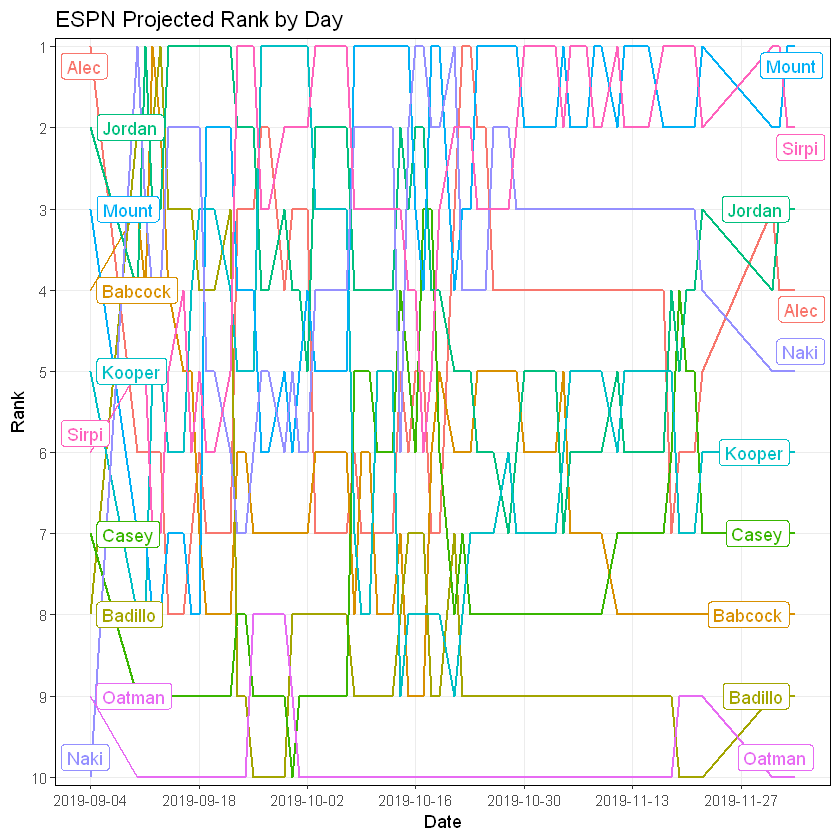

In [7]:
#all dates plot
plot_full <- ggplot(full_dates_long,
                    aes(x = Date, y = Rank, group = Team, colour = Team)) +
  geom_line(size = 0.8) +

  #this makes sure the top ranked team is at the top of the graph
  scale_y_reverse(breaks = seq(1, 14, 1),
                  expand = c(0.01, 0.01)) +

  #the options are to span the entire graph, not too much white space,
  #and to have x axis labels per 2 weeks
  scale_x_date(expand = c(0.05, 0.05),
               breaks = c(seq(draft_day, maxim_day, 14))) +
  labs(x = "Date",
       title = "ESPN Projected Rank by Day") +
  theme(panel.border = element_rect(colour = "black", fill = NA),
        plot.background = element_rect(fill = "white"),
        panel.background = element_rect(fill = "white"),
        panel.grid.major = element_line(size = 0.5, linetype = "solid",
                                        colour = "#ececec"),
        legend.position = "none") +

  #this is the extra columns created above
  #this creates a label at the beginning and end of each line
  geom_label_repel(aes(label = label_max),
                   nudge_x = 1,
                   na.rm = TRUE) +
  geom_label_repel(aes(label = label_min),
                   nudge_x = -1,
                   na.rm = TRUE)

plot_full

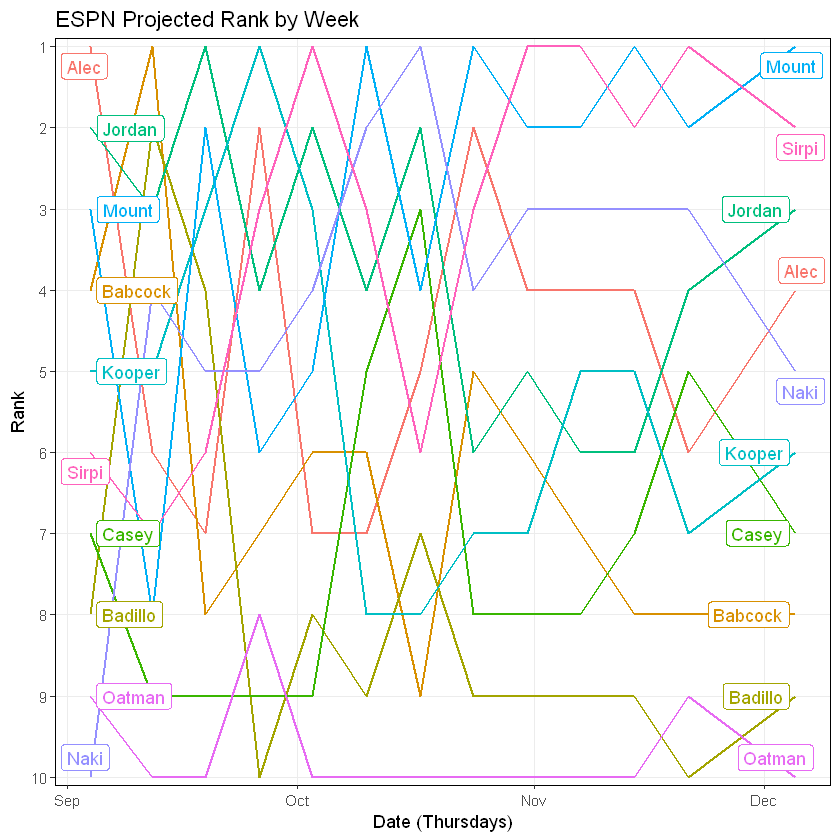

In [8]:
#thursdays plot
plot_thu <- ggplot(analysis_long,
                   aes(x = Date_fix, y = Rank, group = Team, colour = Team)) +
  geom_line(size = 0.8) +
  scale_y_reverse(breaks = seq(1, 14, 1),
                  expand = c(0.01, 0.01)) +
  scale_x_date(expand = c(0.05, 0.05)) +
  labs(x = "Date (Thursdays)",
       title = "ESPN Projected Rank by Week") +
  theme(panel.border = element_rect(colour = "black", fill = NA),
        plot.background = element_rect(fill = "white"),
        panel.background = element_rect(fill = "white"),
        panel.grid.major = element_line(size = 0.5, linetype = "solid",
                                        colour = "#ececec"),
        legend.position = "none") +
  geom_label_repel(aes(label = label_max),
                   nudge_x = 1,
                   na.rm = TRUE) +
  geom_label_repel(aes(label = label_min),
                   nudge_x = -1,
                   na.rm = TRUE)

plot_thu

These images are better viewed when output as a separate object instead of embedded in a Notebook. This allows the image to be stretched wider and not seem as squished. That being said, a helpful way to distinguish between lines is to add a label box within the image itself instead of at the beginning and end of each line:

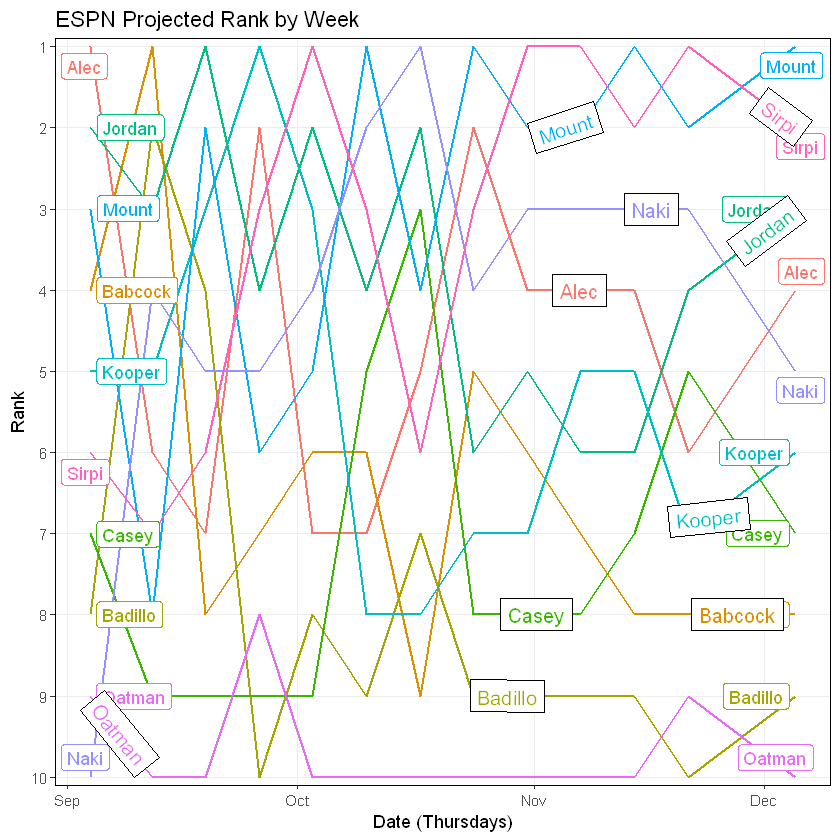

In [9]:
#for a label in the middle of the line plot
direct.label(plot_thu, "angled.boxes")

I haven't yet figured out where to place the angled boxes, since it seems to be automatic. Nevertheless, it at the least helps identify which line corresponds to each team.

So, even though we have a multiple line chart of all these final rankings, and even though it's split by weeks, the visual is still kind of illegible. Reading and following a league member takes an overtly conscious effort which goes against Graphic Development 101. Therefore, we'll create another type of visual. A matrix of images in which every line for every player is present, albeit very light and hidden. Each individual league member's ranking throughout the season will be highlighted. This is easier to see in practice compared to written text:

In [10]:
#creating a vector of team names
teams <- name_column %>% pull(Team)
teams

[1] "Alec"    "Jordan"  "Mount"   "Babcock" "Kooper"  "Sirpi"   "Casey"  
 [8] "Badillo" "Oatman"  "Naki"

In [11]:
#creating a vector of divergent colors
gg_color_hue <- function(n) {
  hues = seq(15, 375, length = n + 1)
  hcl(h = hues, l = 65, c = 100)[1:n]
}
colors <- gg_color_hue(10)
colors

[1] "#F8766D" "#D89000" "#A3A500" "#39B600" "#00BF7D" "#00BFC4" "#00B0F6"
 [8] "#9590FF" "#E76BF3" "#FF62BC"

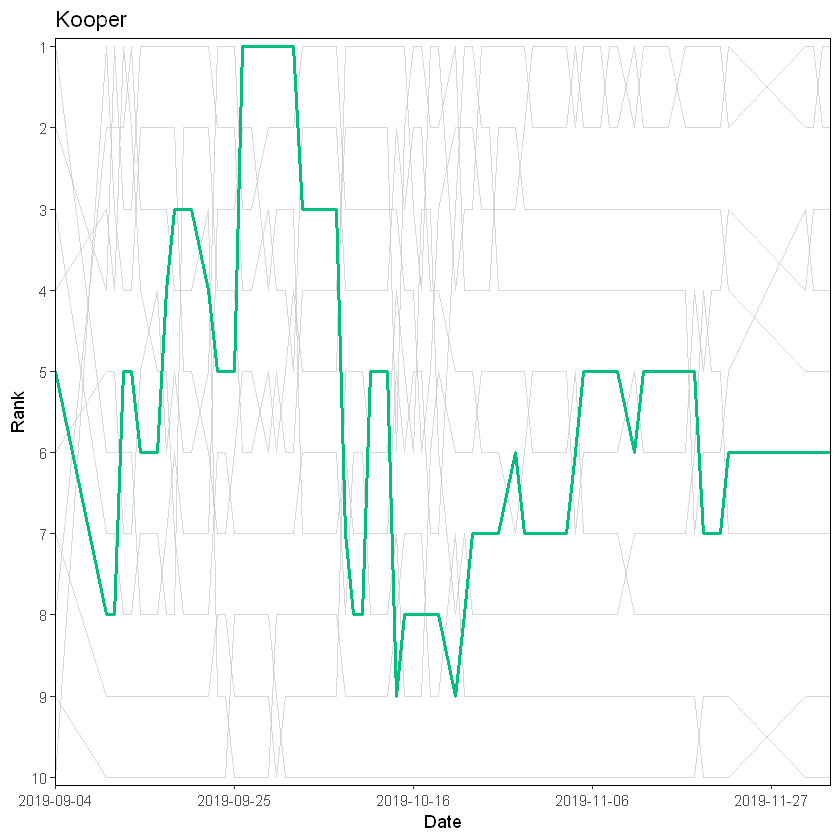

In [12]:
#initialize an empty list, then fill it with everyone's graph
#empty list of plots
graphs <- vector(mode = "list", length = length(teams))

for (i in 1:length(teams)) {
  graphs[[i]] <- ggplot() +
    geom_line(aes(x = Date,
                  y = Rank,
                  group = Team),
              data = full_dates_long,
              colour = alpha("grey", 0.6)) +
    geom_line(aes(x = Date,
                  y = Rank),
              data = full_dates_long %>% 
                filter(Team == teams[i]),
              size = 1,
              colour = colors[i]) +
    theme(panel.border = element_rect(colour = "black", fill = NA),
          plot.background = element_rect(fill = "white"),
          panel.background = element_rect(fill = "white"),
          legend.position = "none") +
    scale_y_reverse(breaks = seq(1, 14, 1),
                    expand = c(0.01,0.01)) +
    scale_x_date(breaks = c(seq(draft_day, maxim_day, 21)),
                 expand = c(0,0)) +
    labs(x = "Date",
         title = (teams[i]))
}

graphs[[5]]

This looks a lot more visually pleasing. We can see exactly how Kooper's projection changed through the season even with everyone else's data hidden in the background. Now the matrix of images:

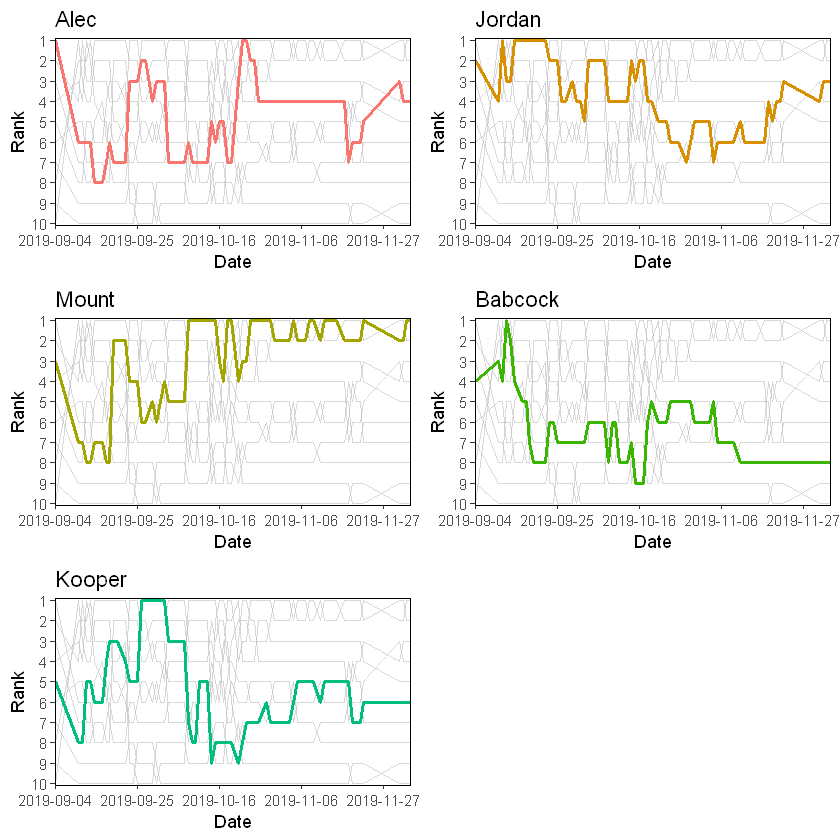

In [13]:
grid.arrange(graphs[[1]], graphs[[2]], graphs[[3]], graphs[[4]], graphs[[5]])

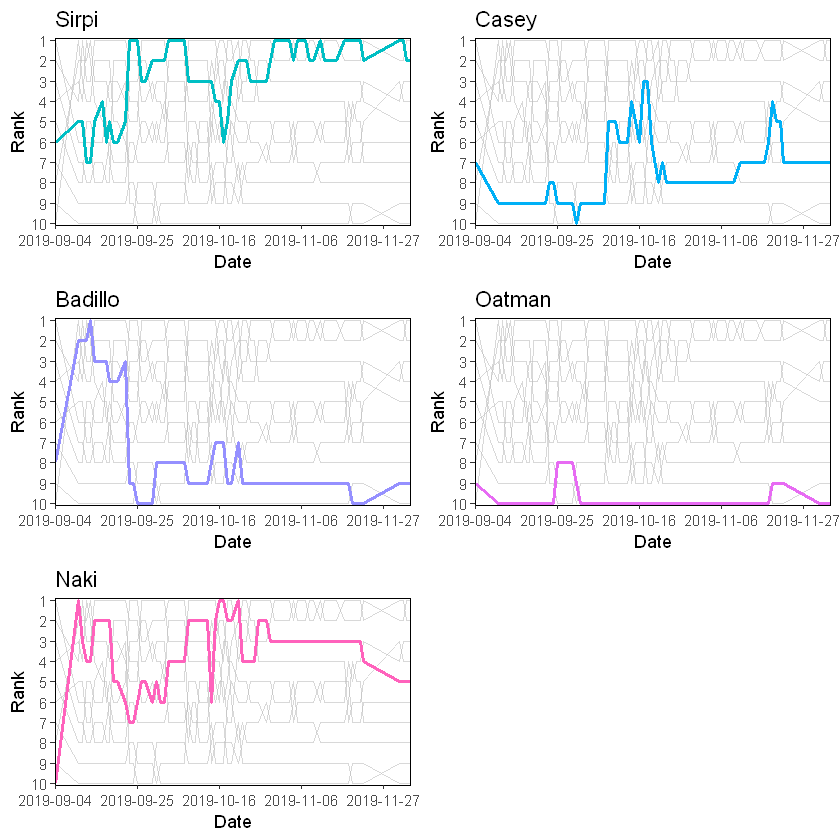

In [14]:
grid.arrange(graphs[[6]], graphs[[7]], graphs[[8]], graphs[[9]], graphs[[10]])

### Accuracy
We can see how the trends changed. But how accurate were they? Keep in mind the algorithm clearly cannot predict in-season trades and waiver-wire transactions. That being said, there's a saying that in Fantasy, a player can lose a league with his draft even if he can't win one.

First, we create the dataset that contrasts the draft day final projected ranking with the actual final ranking (equal to the final projected ranking on the last day of the fantasy regular season):

In [15]:
source_cs <- source[, c(1, 2, length(source))] %>% 
  mutate(diff = `43804` - `43712`)
source_cs

Team,43712,43804,diff
Alec,1,4,3
Jordan,2,3,1
Mount,3,1,-2
Babcock,4,8,4
Kooper,5,6,1
Sirpi,6,2,-4
Casey,7,7,0
Badillo,8,9,1
Oatman,9,10,1
Naki,10,5,-5


Without spending too much time renaming variables in concordance to appropriate dates, we list the expected and observed final rankings. A column <code>diff</code> is the difference between the two columns. To test for a difference between the two columns, we develop the following 2 hypothesis:

$H_{0}:$ There is an absence of association between the 2 columns.
<br>
$H_{A}:$ There is an association between the 2 columns.

The null hypothesis assumes that the two columns are not statistically significantly the same, and the alternative is that they are. To test this null hypothesis, we will use the Kendall rank correlation coefficient, or Kendall's Tau. This coefficient is used to measure the ordinal association between two quantities and thus perfect for the type of data we have. Kendall's Tau is implemented in <code>R</code> as such:

In [16]:
cor(source_cs %>% select(`43712`, `43804`), method = "kendall")

,43712,43804
43712,1.0000000,0.3777778
43804,0.3777778,1.0000000


The diagonal is 1, as the correlation between a column and itself is 100%. The other cell is 0.378. This is a decent amount of correlation, but to test it, we'll get a p-value:

In [17]:
cor.test(source_cs$`43712`, source_cs$`43804`, method = "kendall")


	Kendall's rank correlation tau

data:  source_cs$`43712` and source_cs$`43804`
T = 31, p-value = 0.1557
alternative hypothesis: true tau is not equal to 0
sample estimates:
      tau 
0.3777778 


The resulting p-value (which uses the standard normal Z-table after converting the Tau value to a Z-value) is 0.1557. This is greater than the standard 0.05, which means we do not reject the null hypothesis. We instead assume it, that the two columns are not the same: an abssence of association. So, ultimately ESPN predicted only one final rank correctly in Casey, and got 3/4 playoff teams (left out Sirpi).

I guess we can say making the final predictions is difficult, especially when there are so many transactions and other variables that go on through the season. That being said, the variability we observe in some of those line graphs is certainly intriguing.